In [1]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from get_eigenvectors import get_eigenvectors
from pca_detect_digit import pca_detect_digit
from draw_rectangle import draw_rectangle

# Get the absolute path of the script's directory
current_directory = os.getcwd()
# Get the parent directory
parent_directory = os.path.dirname(current_directory)
# Add the parent directory to sys.path
sys.path.append(parent_directory)

Write a Python function called:
mean_digit_vector, eigenvectors = get_eigenvectors(data_file_path, digit)
That behaves as follows:

*Accepts as arguments the path to a .csv text file that contains examples of handwritten digits, and a "digit" label that corresponds to one of the digits 0-9.

*Returns the mean digit as a vector and the eigenvectors for images corresponding to the "digit" parameter.

The mnist_data.csv file contains the 10,000 training examples of 28x28 images of handwritten digits and the corresponding labels. Each row consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255).

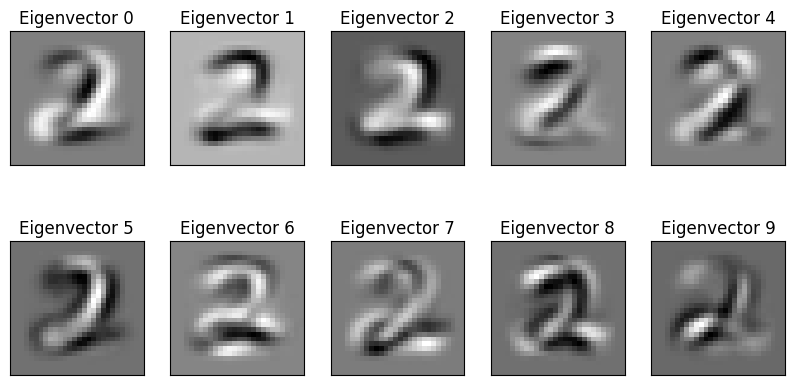

In [2]:
#def get_eigenvectors(data_file_path, digit):
#return mean_vector, eigenvectors
data_file_path = os.path.join(current_directory, 'data', 'mnist_data.csv')
digit = 2

# Load the data from the CSV file
data = np.loadtxt(data_file_path, delimiter=',')

# Extract the labels and image data
labels = data[:, 0]
images = data[:, 1:]

# Filter the data to get only the images of the specified digit
digit_images = images[labels == digit]

# Reshape the 28x28 images to 784-dimensional vectors
digit_images = digit_images.reshape((digit_images.shape[0], 28 * 28))

# Normalize the images to have zero mean and unit variance
mean_image = np.mean(digit_images, axis=0)
normalized_images = digit_images - mean_image

# Calculate the standard deviation and add a small epsilon to avoid division by zero
#std_dev = np.std(normalized_images, axis=0)
#epsilon = 1e-10  # Small epsilon to prevent division by zero
#std_dev = np.maximum(std_dev, epsilon)

# Calculate the covariance matrix and perform PCA
covariance_matrix = np.cov(normalized_images, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

#return mean_image, eigenvectors

Write a function that is called: 
detection_center = pca_detect_digit(image, mean_digit, eigenvectors, N
)
that takes as arguments an image (such as the noisy images shown in Figure 1), the mean digit image (28x28 2D array), the eigenvectors as computed in Task 1 for the digit "2", and a number N that specifies how many eigenvectors to us

e. Your function should evaluate each subwindow of size 28x28 of the input image based on the sum of squared differences between the original subwindow, and the reconstruction of the subwindow using the top N eigenvector

s. Your function should NOT search over multiple scales. Also, your function should rely only on PCA, and should NOT use any other techniques. Furthermore, your pca_detect_digit should satisfy the following specifications:

It returns a 1x2 matrix (one row, two columns), containing the row (first) and column (second) of the center of the best-matching subwi

Use the samples in test_data.zip to test your function, with N=10 (i.e., using the top 10 eigenvectors).
If we define "correct detection" to mean that the digit is completely inside the bounding box, my solution detects correctly the twos in 18 out of 20 images of twos.

Tips:

1. To load the mnist_data.csv data file you can use np.loadtxt with the character ',' as the delimiter.

2. Before applying PCA on the 28x28 MNIST images, make sure they have been converted to 784-dimensional vectors and have normalized each image vector to zero mean and unit vector.

3. The reconstruction error of each 28x28 subwindow of the test image can be computed by first converting that window into a 784-dimensional vector, projecting it to 10-dimensions using the top 10 principal components, and then back-projecting it to a 784-dimensional vector. The sum of squared pixel differences of the original vector with the reconstructed one is the reconstruction error. 

4. Make sure you understand when to use an image as a 2D array, and when to use it as a flattened vector. Also, make you apply the same types of normalization to all your images/vectors.ndow.

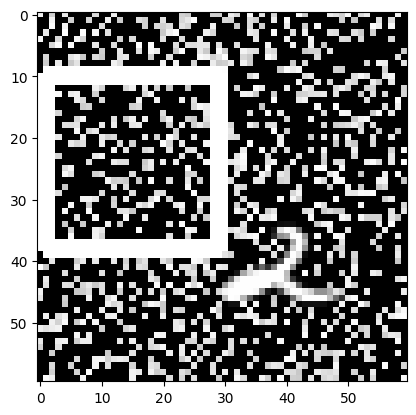

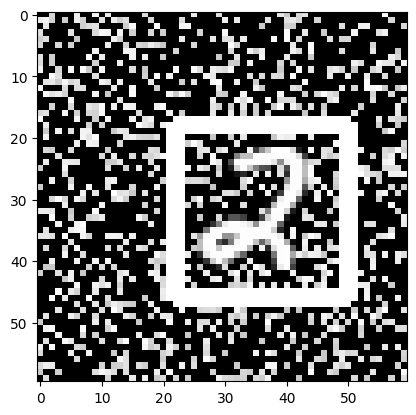

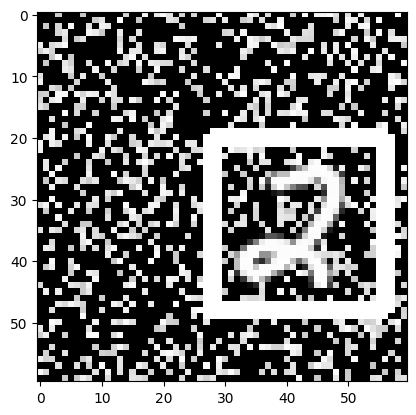

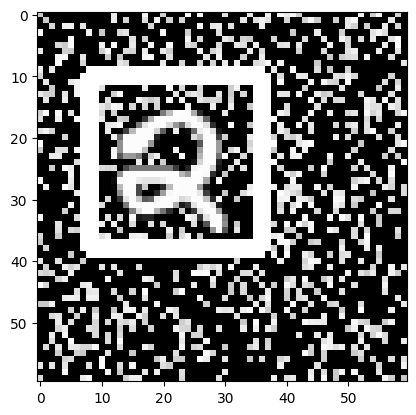

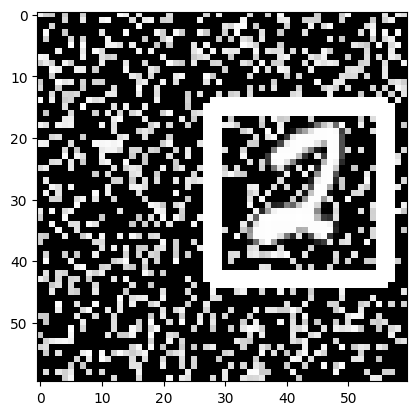

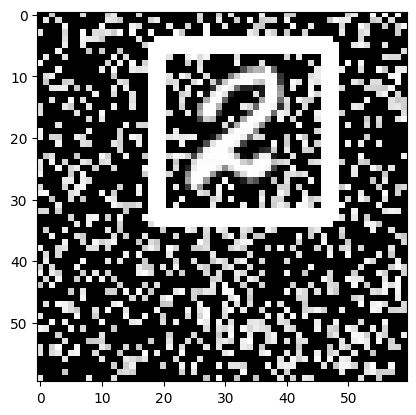

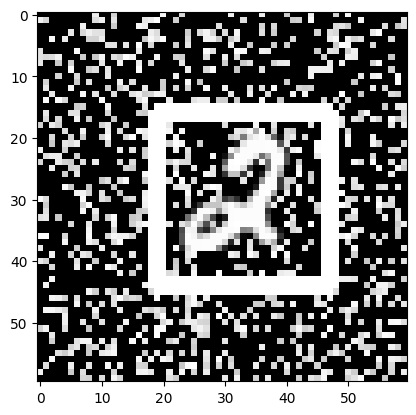

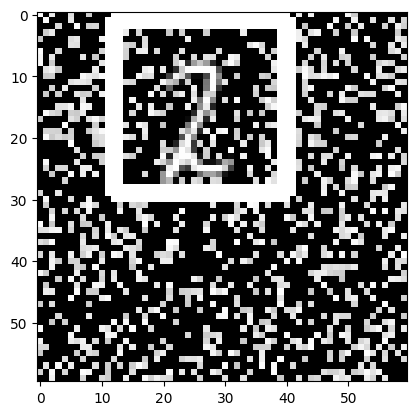

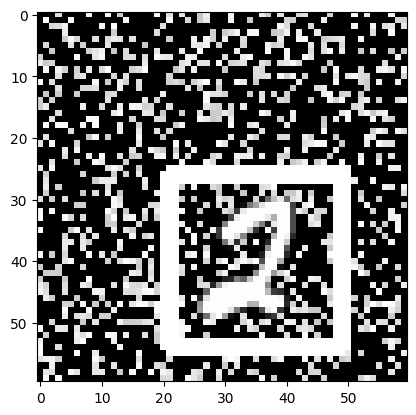

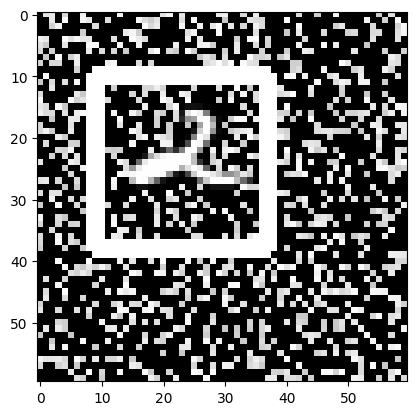

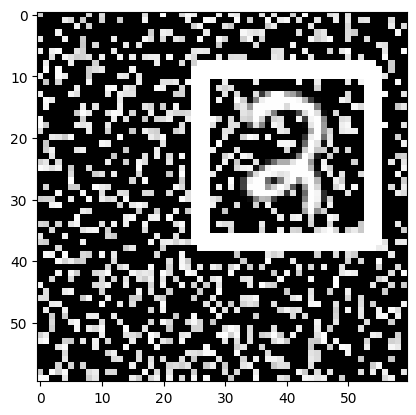

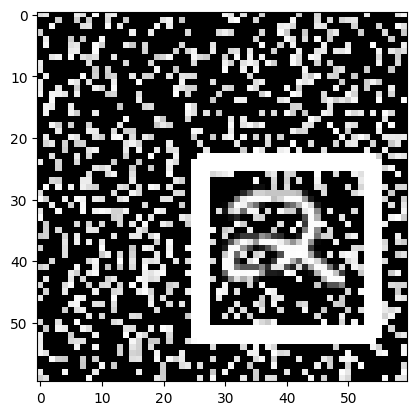

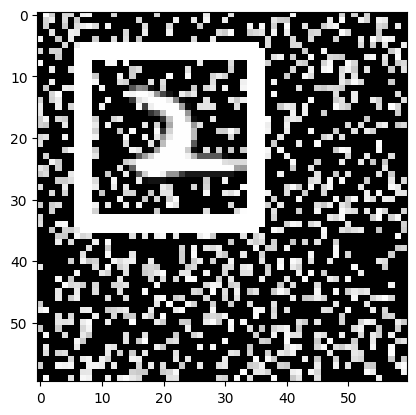

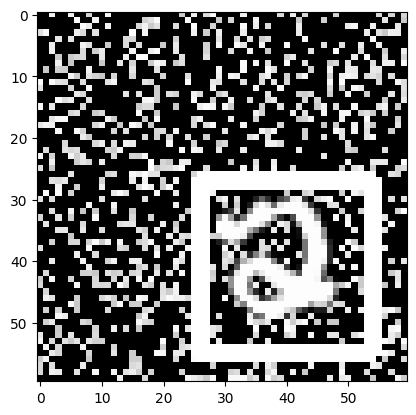

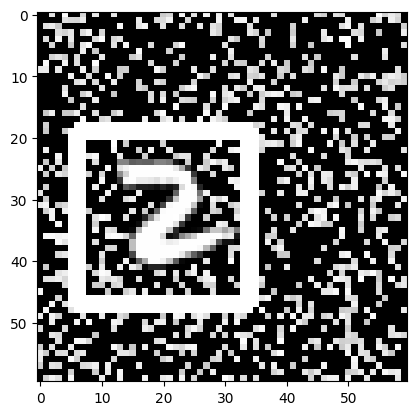

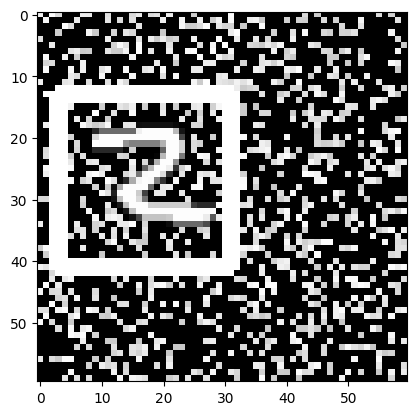

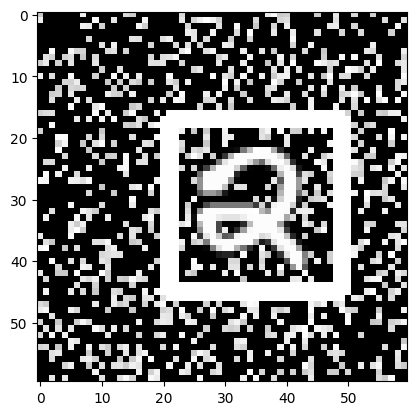

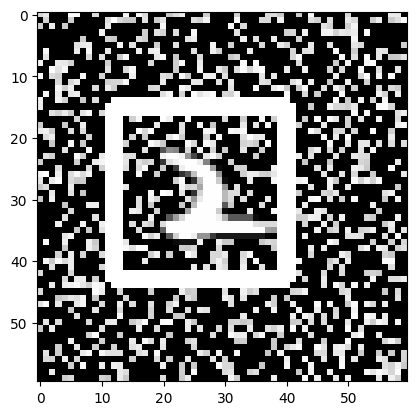

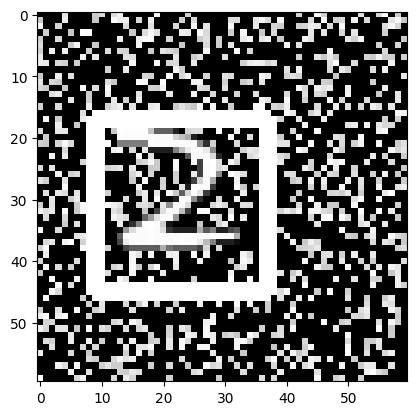

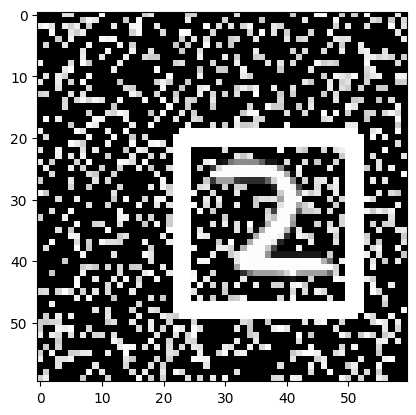

In [54]:
#def pca_detect_digit(image, mean_digit, eigenvectors, N):
#return detection_center
test_data_dir = os.path.join(current_directory, 'data', 'test_data')
test_data_files = os.listdir(test_data_dir)
mean_digit = mean_image.reshape(28, 28)
N=10
subwindow_size = 28

for test_data_file in test_data_files:
    image = cv2.imread(os.path.join(test_data_dir, test_data_file), cv2.IMREAD_GRAYSCALE)

    # Calculate the mean and standard deviation of the input image
    mean_input_image = np.mean(image)
    std_dev_input_image = np.std(image)
    
    # Normalize the input image using its own mean and standard deviation
    normalized_input_image = (image - mean_input_image) / (std_dev_input_image + 1e-10)

    # Get the dimensions of the input image
    rows, cols = normalized_input_image.shape
    
    #Initialize variables to keep track of the best match
    best_error = float('inf')
    best_center = (0, 0)
    
   # Iterate over subwindows in the input image
    for row in range(rows - subwindow_size + 1):
        for col in range(cols - subwindow_size + 1):
            
            # Extract the subwindow
            subwindow = normalized_input_image[row:row + subwindow_size, col:col + subwindow_size]

            # Convert the subwindow into a 784-dimensional vector
            subwindow_vector = subwindow.reshape(784)
            
            # Normalize the subwindow by subtracting the mean_digit
            normalized_subwindow = subwindow_vector - mean_digit.reshape(784)

            # Project the normalized subwindow onto the top N eigenvectors
            projection = np.dot(normalized_subwindow, eigenvectors[:, :N])

            # Reconstruct the subwindow from the projection
            reconstructed_subwindow = np.dot(projection, eigenvectors[:, :N].T)

            # Calculate the sum of squared differences (SSD) as the reconstruction error
            error = np.sum((subwindow_vector - reconstructed_subwindow) ** 2)

            # If the current SSD is better than the best match, update the best match

            if error < best_error:
                best_error = error
                best_center = (row + subwindow_size // 2, col + subwindow_size // 2)
    
    #return best_center